# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

set.seed(314159265)

Loading ychr



### Estimate TMRCA of A00 and present-day non-Africans

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98)

In [3]:
step1 <- run_step1(highcov_gt)

### Estimate TMRCA between archaic Y chromosomes and present-day humans

All variations of filtering, substitution types, coverage cutoffs...

In [4]:
estimate_grid <- function(samples, regions, mindp) {
    filters <- c("filt50" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz",
                 "filt100" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz")
    
    map_dfr(samples, function(arch) {
        map_dfr(c("all", "nodmg"), function(sites) {
            map_dfr(c("filt50", "filt100"), function(filt) {
                future_map_dfr(mindp, function(dp) {
                    read_genotypes(arch, regions, mindp = dp, maxdp = 0.98, nodmg = (sites == "nodmg"),
                                   bed_filter = filters[filt]) %>%
                        run_step2(step1) %>%
                        mutate(dp = dp, sites = sites, filt = filt, capture = regions)
                })
            })
        })
    })
}

In [5]:
tmrca_deam <- estimate_grid(c("den4_deam", "den8_deam", "spy1_deam", "den_merged_deam", "mez2_deam"), "full", 1:5)

In [6]:
saveRDS(tmrca_deam, here("data/rds/tmrca_deam.rds"))

## Analysis of samples restricted to only deaminated reads

In [2]:
step1 <- readRDS(here("data/rds/step1.rds"))

In [3]:
tmrca_deam <- readRDS(here("data/rds/tmrca_deam.rds"))

In [4]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [5]:
tmrca_df <- bind_rows(tmrca_df, tmrca_deam)

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”
Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”


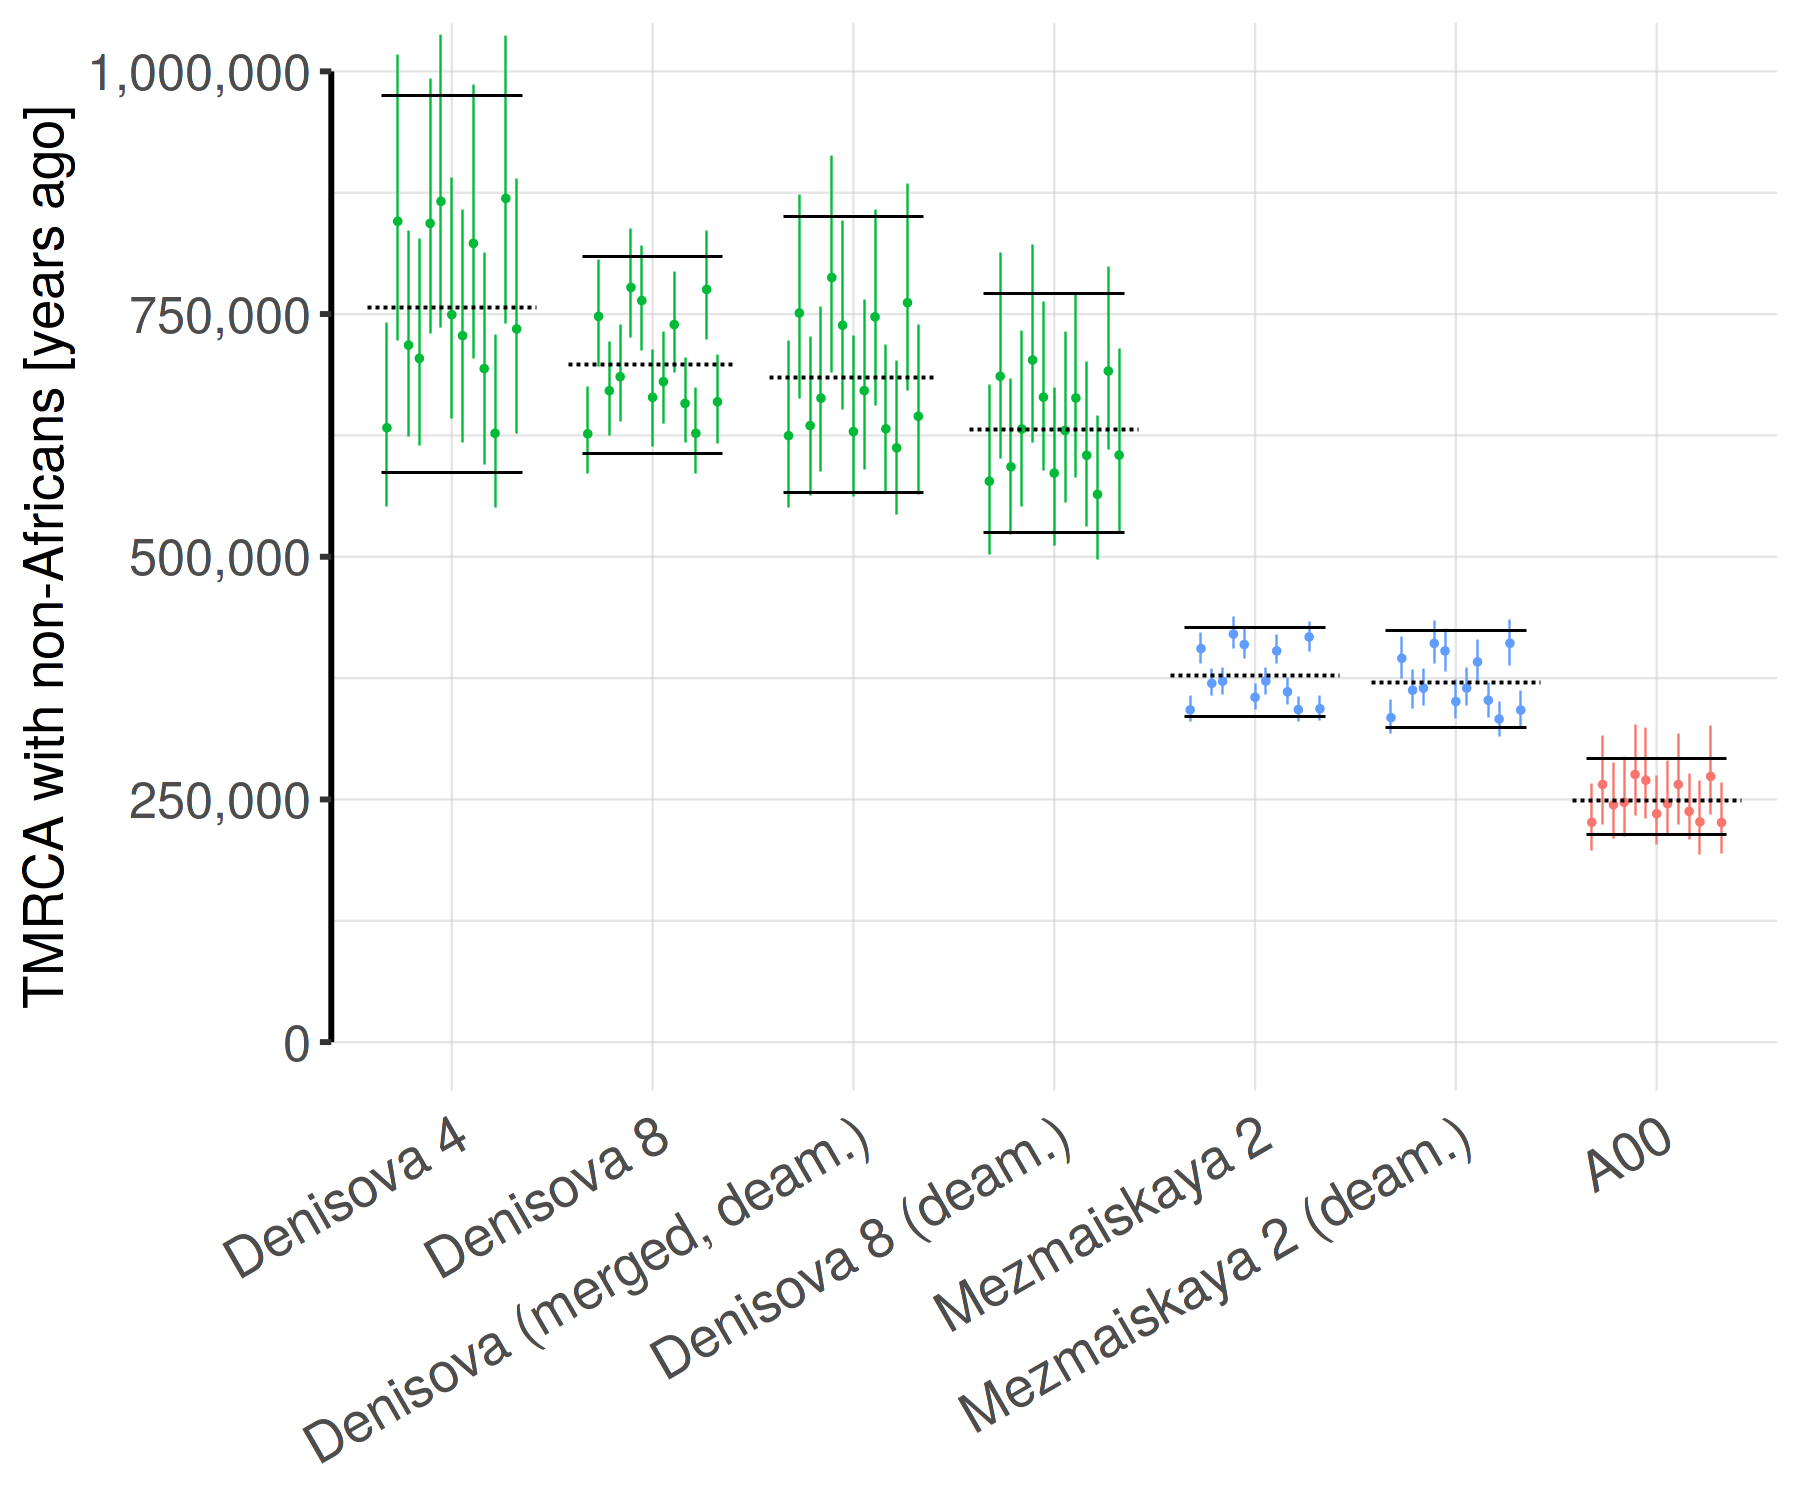

In [6]:
set_dim(6, 5)

plot_tmrca(stat = "new", afr = "a00", mindp = 3, sites = "all", filt = "filt50",
           exclude = c(paste0("mez2_dp", 1:10), "elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad",
                       "den", "den_snpad", "den4_snpad", "den8_snpad", "spy1_snpad",
                       "spy1_deam", "den4_deam", "spy1", "elsidron2"))

In [22]:
tmrca_df %>% filter(str_detect(arch, "mez2$|mez2_deam|den8$|den8_deam"), afr == "a00", dp == 3, filt == "filt50") %>% group_by(afr, arch) %>% 
summarise_if(is.numeric, mean)

afr,arch,a,b,c,d,e,f,total,mut_rate,tmrca_afr,tmrca_mendez,tmrca_new,dp
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a00,den8,722.88462,21.73077,11.038462,398.53846,507.84615,852.92308,3387375.1,7.336567e-10,249211.6,647101.1,702507.3,3
a00,den8_deam,135.96154,3.50000,3.115385,96.42308,128.65385,382.65385,869740.5,7.336567e-10,249211.6,543096.7,592982.7,3
a00,mez2,392.53846,30.15385,20.846154,780.61538,766.11538,892.03846,5374423.8,7.336567e-10,249211.6,374977.8,373791.9,3
a00,mez2_deam,162.15385,19.23077,10.884615,344.73077,460.11538,531.23077,3287093.3,7.336567e-10,249211.6,348144.4,365279.8,3
a00,shotgun_mez2,26.61538,4.50000,2.884615,45.92308,48.92308,84.34615,376729.0,7.336567e-10,249211.6,392589.4,395061.2,3
